In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
print(tf.__version__)

from tensorflow.contrib import rnn

1.5.0


###  Пример однослойной LSTM сети

In [7]:
tf.reset_default_graph()

In [8]:
class SeriesPredictor:
    def __init__(self, input_dim, seq_size, hidden_dim=10):
        # Гиперпараметры
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        
        self.W_out = tf.Variable(tf.random_normal([hidden_dim ,1]), name='W_out') # Add tf.random_normal to fix tile error
        self.b_out = tf.Variable(tf.random_normal([1]), name='b_out')
        self.x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
        self.y = tf.placeholder(tf.float32, [None, seq_size])
        
        self.cost = tf.reduce_mean(tf.square(self.model() - self.y)) #MSE
        self.train_op = tf.train.AdamOptimizer().minimize(self.cost)
        
        self.saver = tf.train.Saver()
        
    def model(self):
        '''
        x - input size [T, batch_size, input_size]
        '''
        cell = rnn.BasicLSTMCell(self.hidden_dim, reuse=tf.get_variable_scope().reuse)
        outputs, states = tf.nn.dynamic_rnn(cell, self.x, dtype=tf.float32)
        num_examples = tf.shape(self.x)[0]
        W_repeated = tf.tile(tf.expand_dims(self.W_out, 0), [num_examples, 1, 1])
        
        out = tf.matmul(outputs, W_repeated) + self.b_out
        out = tf.squeeze(out)
        
        return out
    
    def train(self, train_x, train_y):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            for i in range(1000):
                _, mse = sess.run([self.train_op, self.cost], feed_dict={self.x: train_x, self.y: train_y})
                if i % 100 == 0:
                    print(i, mse)
                    save_path = self.saver.save(sess, './data/chapter_10/model.ckpt')
                    print('Model saved to :', save_path)
                
    def test(self, test_x):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            self.saver.restore(sess, './data/chapter_10/model.ckpt')
            output = sess.run(self.model(), feed_dict={self.x: test_x})
            return output
                    

In [9]:
predictor = SeriesPredictor(input_dim=1, seq_size=4, hidden_dim=10)
train_x = [[[1], [2], [5], [6]],
           [[5], [7], [7], [8]],
           [[3], [4], [5], [7]]]
train_y = [[1, 3, 7, 11],
           [5, 12, 14, 15],
           [3, 7, 9, 12]]
predictor.train(train_x, train_y)

test_x = [[[1], [2], [3], [4]], 
          [[4], [5], [6], [7]]]  
actual_y = [[[1], [3], [5], [7]],
            [[4], [9], [11], [13]]]
pred_y = predictor.test(test_x)

print("\nLets run some tests!\n")

for i, x in enumerate(test_x):
    print("When the input is {}".format(x))
    print("The ground truth output should be {}".format(actual_y[i]))
    print("And the model thinks it is {}\n".format(pred_y[i]))


0 122.60974
Model saved to : ./data/chapter_10/model.ckpt
100 76.20094
Model saved to : ./data/chapter_10/model.ckpt
200 33.75389
Model saved to : ./data/chapter_10/model.ckpt
300 14.36016
Model saved to : ./data/chapter_10/model.ckpt
400 7.8575435
Model saved to : ./data/chapter_10/model.ckpt
500 5.573517
Model saved to : ./data/chapter_10/model.ckpt
600 4.408064
Model saved to : ./data/chapter_10/model.ckpt
700 3.4585724
Model saved to : ./data/chapter_10/model.ckpt
800 2.6551015
Model saved to : ./data/chapter_10/model.ckpt
900 2.0023189
Model saved to : ./data/chapter_10/model.ckpt
INFO:tensorflow:Restoring parameters from ./data/chapter_10/model.ckpt

Lets run some tests!

When the input is [[1], [2], [3], [4]]
The ground truth output should be [[1], [3], [5], [7]]
And the model thinks it is [1.2147193 3.2669868 6.097159  8.508504 ]

When the input is [[4], [5], [6], [7]]
The ground truth output should be [[4], [9], [11], [13]]
And the model thinks it is [ 3.9823792  8.744963  11.

### Модель для временного ряда

In [53]:
tf.reset_default_graph()

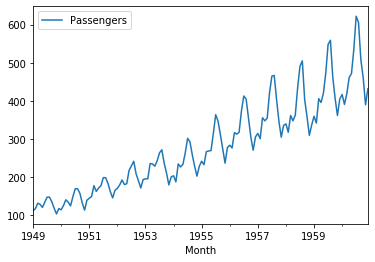

In [54]:
URL = 'https://raw.githubusercontent.com/blue-yonder/pydse/master/pydse/data/international-airline-passengers.csv'
time_data = pd.read_csv(URL, sep=';')
time_data['Month'] = pd.to_datetime(time_data['Month'])
time_data.set_index('Month', inplace = True)
time_data.plot()
plt.show()

In [55]:
time_data['Passengers_norm'] = (time_data['Passengers'] - np.mean(time_data['Passengers']))/np.std(time_data['Passengers'])

In [56]:
def split_data(x, train_ratio=0.8):
    train_data = x[:int(len(x) * train_ratio)]
    test_data = x[int(len(x) * train_ratio):]
    return train_data, test_data

In [57]:
def plot_results(train_x, predictions, actual, filename=None):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

In [58]:
seq_size = 5
predictor = SeriesPredictor(input_dim=1, seq_size=seq_size, hidden_dim=100)
train_data, actual_vals = split_data(time_data['Passengers_norm'])

train_x, train_y = [], []
for i in range(len(train_data) - seq_size - 1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1])

test_x, test_y = [], []
for i in range(len(actual_vals) - seq_size - 1):
    test_x.append(np.expand_dims(actual_vals[i:i+seq_size], axis=1).tolist())
    test_y.append(actual_vals[i+1:i+seq_size+1])

In [59]:
predictor.train(train_x, train_y) # Поскольку имя модели не является параметром класса, мы перезапишем старые файлы с прошлого шага

0 1.6713176
Model saved to : ./data/chapter_10/model.ckpt
100 0.08278237
Model saved to : ./data/chapter_10/model.ckpt
200 0.048039343
Model saved to : ./data/chapter_10/model.ckpt
300 0.043725643
Model saved to : ./data/chapter_10/model.ckpt
400 0.04215018
Model saved to : ./data/chapter_10/model.ckpt
500 0.04101124
Model saved to : ./data/chapter_10/model.ckpt
600 0.039941587
Model saved to : ./data/chapter_10/model.ckpt
700 0.039278816
Model saved to : ./data/chapter_10/model.ckpt
800 0.038845956
Model saved to : ./data/chapter_10/model.ckpt
900 0.038462337
Model saved to : ./data/chapter_10/model.ckpt


In [65]:
pred_y = predictor.test(test_x)[:, 0]

INFO:tensorflow:Restoring parameters from ./data/chapter_10/model.ckpt


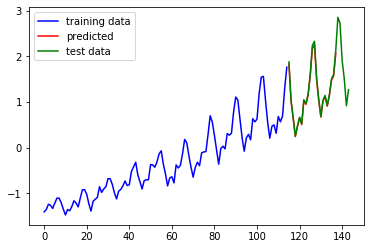

In [66]:
plot_results(train_data, pred_y, actual_vals)